# Data exploration and visualization

This dataset is a 4G LTE mobile network counters data for a major MENA operator on Huawei infra. The dataset being worked on is a subset of the full dataset focused on countes used to calcualte high level performance KPIs for a period of one week. This notebook is an initial data exploration and visualization for this dataset before jumping into any forecasting modeling

### Load libraries required for the analysis

In [973]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
import calendar
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

### Load the dataset and check the data type

In [997]:
df=pd.read_excel('Traffic.xlsx')
df.head()

,Start Time,Cell,L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None),L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None),L.Traffic.UL.SCH.QPSK.TB (None),L.Traffic.UL.SCH.QPSK.TB.bits (bit),L.Traffic.UL.SCH.QPSK.TB.Retrans (None),L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit),L.Traffic.DL.PktDelay.Num.QCI.9 (packet),L.Traffic.DL.PktDelay.Time.QCI.9 (ms),...,L.Traffic.UL.SCH.16QAM.TB (None),L.Traffic.UL.SCH.16QAM.TB.bits (bit),L.Traffic.UL.SCH.16QAM.TB.Retrans (None),L.Traffic.UL.SCH.16QAM.TB.Retrans.bits (bit),L.Traffic.UL.SCH.64QAM.ErrTB.Ibler (None),L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None),L.Traffic.UL.SCH.64QAM.TB (None),L.Traffic.UL.SCH.64QAM.TB.bits (bit),L.Traffic.UL.SCH.64QAM.TB.Retrans (None),L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit)
0,2013-08-28,"Local cell identity=2, Cell Name=eNB_2786_2",16296,2631,153575,101906552,26414,15092480,785527,190975757,...,513181,1215761008,40201,98515328,0,0,0,0,0,0
1,2013-08-28,"Local cell identity=1, Cell Name=eNB_2282_1",12856,433,111023,87983752,15671,10747464,1428194,753605164,...,670664,1167179360,47727,94020520,0,0,0,0,0,0
2,2013-08-28,"Local cell identity=0, Cell Name=eNB_2786_0",13636,641,132016,89939024,17448,10200736,1002134,290990065,...,819410,1921970648,49922,117234944,0,0,0,0,0,0
3,2013-08-28,"Local cell identity=0, Cell Name=eNB_5265_0",11903,82,126081,151564696,12790,20082880,617281,98672335,...,969115,1215749536,38963,53750968,0,0,0,0,0,0
4,2013-08-28,"Local cell identity=2, Cell Name=eNB_5265_2",41385,7867,259625,183131112,76076,32228320,1121723,510453204,...,561853,1208172496,44483,105478408,0,0,0,0,0,0


What are we dealing with here? it's a dataset that has a time stamp, along with the name of the cell. The cells are the 4G LTE sites that provide coverage to the service area. Each cell has a reading every 15 minutes as seen below (taken for one cell as an example). There are 768 readings for each cell which amounts to a full week's data. As seen in the head results, each column has numeric values for each reading. Each column is called a "counter" as it counts/calculates one variable every 15 mins and records it in the the dataset

In [998]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df_subset=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_2786_2']
df_subset['Start Time']

0        2013-08-28 00:00:00
484      2013-08-28 00:15:00
564      2013-08-28 00:30:00
824      2013-08-28 00:45:00
1190     2013-08-28 01:00:00
                 ...        
209057   2013-09-04 22:45:00
209331   2013-09-04 23:00:00
209605   2013-09-04 23:15:00
209879   2013-09-04 23:30:00
210153   2013-09-04 23:45:00
Name: Start Time, Length: 768, dtype: datetime64[ns]

Ok. What columns are we dealing with? Let's have a look

In [895]:
df.columns

Index(['Start Time', 'Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 

There are a number of counters here. Counters included in the dataset are for each layer in the tech stack of 4G LTE airinterface. We are dealing in particular with PHY (bits transmitted/received, time to send/receive, block error rate for each modulation type etc..), MAC (packets transmitted/received), PDCP (Packets count, packets loss, PDCP compression stats), and NAS (Non-access startum session timers and counters). These counters and be used by themselves or in combination to come up with KPIs to monitor the performance/functionality of the 4G LTE network

What are the types of columns that we have? the expectation is to be dealing with numeric data. is that what we see?

In [896]:
df.dtypes

Start Time                                      datetime64[ns]
Cell                                                    object
L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)                 int64
L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)                 int64
L.Traffic.UL.SCH.QPSK.TB (None)                          int64
                                                     ...      
L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None)                int64
L.Traffic.UL.SCH.64QAM.TB (None)                         int64
L.Traffic.UL.SCH.64QAM.TB.bits (bit)                     int64
L.Traffic.UL.SCH.64QAM.TB.Retrans (None)                 int64
L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit)             int64
Length: 82, dtype: object

Looks like the majority of the columns are numeric as expected. Cell name is an object as expected. Start time, which is a time stamp, was read correctly as datetime. Let's set Start time as the index of the dataframe as we are interested in analyzing the dataset as timeseries data. Also let's check the count of each data type in the dataset

In [999]:
df.set_index('Start Time',drop=False,inplace=True)
df.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:00:00',
               '2013-08-28 00:00:00', '2013-08-28 00:00:00',
               '2013-08-28 00:00:00', '2013-08-28 00:00:00',
               '2013-08-28 00:00:00', '2013-08-28 00:00:00',
               '2013-08-28 00:00:00', '2013-08-28 00:00:00',
               ...
               '2013-09-04 23:45:00', '2013-09-04 23:45:00',
               '2013-09-04 23:45:00', '2013-09-04 23:45:00',
               '2013-09-04 23:45:00', '2013-09-04 23:45:00',
               '2013-09-04 23:45:00', '2013-09-04 23:45:00',
               '2013-09-04 23:45:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=256493, freq=None)

In [1000]:
df.dtypes.value_counts()

int64             74
float64            5
object             2
datetime64[ns]     1
dtype: int64

Seems like there are two object columns, which is not expected. We expect to have one only (Cell name). Let's check what the second one is

In [1001]:
obj_cols = []
for col in df.columns:
    if df[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

['Cell', 'DL RBLER (%)']

DL BLER (Block error rate) was read as an objet for some reason. This is not expected as we should be dealing with a float here (values from 0 to 1). Are there any missing values that were read as strings for example in the dataset? let's check the unique values and find out if any item is non-numeric

In [1007]:
a=list(df['DL RBLER (%)'].unique())


def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

print([x for x in a if not isfloat(str(x))])


['NIL']


Ok...Now it makes sense. There is a value that was read as 'NIL'. Not clear where that came from. But we'll simply set it as na then fill it with the median value in the dataset. Let's also check the non numeric objects' count again

In [1008]:
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
obj_cols = []
for col in df.columns:
    if df[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

['Cell']

DL BLER is numeric now. Mssion accomplished!

A quick look at the Huawei LTE KPI reference shows that some of the user perceived performance KPIs are not found in the counters out of the box and require some calculations. Two of the most important are Downlink user throughput in Mbps (download speed) and total downlink cell throughput in Mbps (total download speed of the cell). The KPI definition defines those two KPIs as seen below (refer to document eNodeB V100R005C00 KPI Reference issue date 2012-03-30)



In [903]:
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)


After adding the two important KPIs, it good to check for any missing values

In [915]:
df.isna().sum()

Start Time                                      0
Cell                                            0
L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)        0
L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)        0
L.Traffic.UL.SCH.QPSK.TB (None)                 0
                                               ..
L.Traffic.UL.SCH.64QAM.TB.bits (bit)            0
L.Traffic.UL.SCH.64QAM.TB.Retrans (None)        0
L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit)    0
DL user tput                                    0
DL cell tput                                    0
Length: 84, dtype: int64

There are 196 missing values for both DL user throughput and DL cell throughput. Let's check the raw data

In [910]:
df[df['DL user tput'].isna()][['L.Thrp.bits.DL.QCI.9 (bit)','L.Thrp.Time.DL.QCI.9 (ms)']]

,L.Thrp.bits.DL.QCI.9 (bit),L.Thrp.Time.DL.QCI.9 (ms)
Start Time,,
2013-08-28 09:30:00,0,0
2013-08-28 09:30:00,0,0
2013-08-28 09:30:00,0,0
2013-08-28 09:30:00,0,0
2013-08-28 09:45:00,0,0
...,...,...
2013-09-01 08:45:00,0,0
2013-09-02 01:15:00,0,0
2013-09-02 05:15:00,0,0


The NA's are due to the counters being all zeros. There were no connected users or traffic going on. Since that is the reason we can replace the NA's with zeros.

In [914]:
df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

### Add dattime related features

Some very useful features to add for timeseries analysis are datetime related features such as day of the week and time of the day. Below we add those features. First day of week is added. to maintain order of days we make sure we set ordered argument to true

In [918]:
df['day_of_week']=df['Start Time'].dt.day_name()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cat_type = CategoricalDtype(categories=cats, ordered=True)
df['day_of_week'] = df['day_of_week'].astype(cat_type)

df['day_of_week'].unique()

[Wednesday, Thursday, Friday, Saturday, Sunday, Monday, Tuesday]
Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]

Time of the day is also added in the form of hour of the day (24 hour format)


In [921]:
df['hour_of_day']=df['Start Time'].dt.strftime('%H')
df['hour_of_day'].unique()

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

### User Download Throughput analysis

On of the major KPIs for user perceived service quality is average user downlink throughput. To understand how this KPI changes over time it is good to aggregate the KPI over different time periods (day of week and hour of day)

In [922]:
plotdays=df.groupby(['day_of_week'])['DL user tput'].mean()
plothours=df.groupby(['hour_of_day'])['DL user tput'].mean()
plotUdays=df.groupby(['day_of_week'])['L.Traffic.User.Avg (None)'].mean()
plotUhours=df.groupby(['hour_of_day'])['L.Traffic.User.Avg (None)'].mean()

In [923]:
plotdays=pd.DataFrame(plotdays)
plotdays['day_of_week']=plotdays.index
plotdays.reset_index(level=None, drop=True, inplace=True)

plothours=pd.DataFrame(plothours)
plothours['hour_of_day']=plothours.index
plothours.reset_index(level=None, drop=True, inplace=True)


plotUdays=pd.DataFrame(plotUdays)
plotUdays['day_of_week']=plotUdays.index
plotUdays.reset_index(level=None, drop=True, inplace=True)


plotUhours=pd.DataFrame(plotUhours)
plotUhours['hour_of_day']=plotUhours.index


plotUhours.reset_index(level=None, drop=True, inplace=True)


First we plot the DL user tput and number of connected user across day of the week

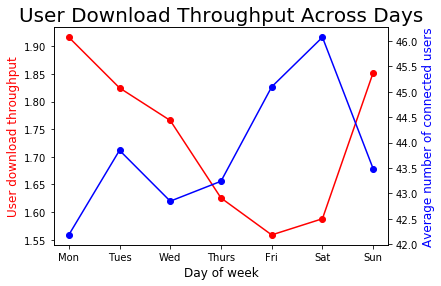

In [927]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.title('User Download Throughput Across Days',fontsize=20);
# make a plot
ax.plot(plotdays['day_of_week'],
        plotdays['DL user tput'],
        color="red", 
        marker="o")

# set x-axis label
ax.set_xlabel("Day of week", fontsize = 12)

# set y-axis label
ax.set_ylabel("User download throughput",
              color="red",
              fontsize=12)



# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(plotUdays['day_of_week'], plotUdays['L.Traffic.User.Avg (None)'],color="blue",marker="o")
ax2.set_ylabel("Average number of connected users",color="blue",fontsize=12)
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=12);
plt.show()



Then we plot DL user tput and number of connected users across hour of the day

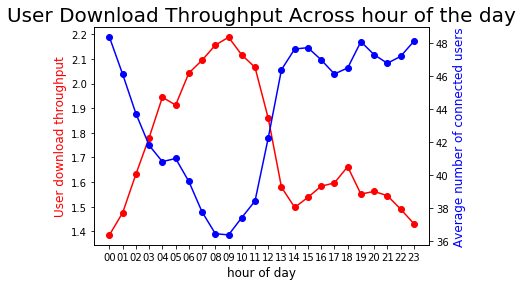

In [928]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.title('User Download Throughput Across hour of the day',fontsize=20);
# make a plot
ax.plot(plothours['hour_of_day'],
        plothours['DL user tput'],
        color="red", 
        marker="o")

# set x-axis label
ax.set_xlabel("hour of day", fontsize = 12)

# set y-axis label
ax.set_ylabel("User download throughput",
              color="red",
              fontsize=12)



# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(plotUhours['hour_of_day'], plotUhours['L.Traffic.User.Avg (None)'],color="blue",marker="o")
ax2.set_ylabel("Average number of connected users",color="blue",fontsize=12)
#plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=12);
plt.show()

Main observations from the plots above:
1) DL user tput and the number of connected users on a cell are inversly related. The higher the number of users the lower the individual downlink throughput. This is seen across hour of the day and day of the week. Thsi is shown again by doing a correlation between the two variables (done in next part)

2) weekends have the lowest user downlink throughput as well as the highest avergae number of connected users

3) Afternnon and evening hours have the lowest user downlink thorughput and highest number of connected users

Above observation is on aggregated data. But does it hold true for all cells or do some cells (or subset of cells) show peaks at different times for example? This question is answered in the next section by doing clustering analysis to see if there are some groups of cells with different behavior

## Unsupervised Cell analysis

One very good way to see if there are some natural groupongs within the cells based on their behavior is to do unsupervised clustering for the cells. One very popular and computationaly efficient way is the k-means clustering algorithm

In [252]:
import matplotlib.pyplot as plt
#from kneed import KneeLocator
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

As a start, and since the the main concern revolves around downlink throughput (both user and cell thorughput), it is good to see if we can find any cell clustering based on thorughput, traffic, and number of users based variables. For that reason 'DL user tput', 'DL cell tput', 'L.Traffic.User.Avg (None)','L.Thrp.bits.DL (bit)' were filtered to be used in this excercise.

One very meaningful KPI that was added was traffic volume per connected user as per the KPI definition document mentioned above

In [936]:
df_cluster=df[['Cell','DL user tput','DL cell tput','hour_of_day','L.Traffic.User.Avg (None)','L.Thrp.bits.DL (bit)']]
df_cluster.reset_index(level=None, drop=True, inplace=True)
df_cluster['hour_of_day']=df_cluster['hour_of_day'].astype(int)

df_cluster['L.Traffic.User.Avg (None)']=df_cluster['L.Traffic.User.Avg (None)'].replace(0.0,1.0)

df_cluster['Traffic Vol per user']=df_cluster['L.Thrp.bits.DL (bit)']/(df_cluster['L.Traffic.User.Avg (None)']*1000000)

#df_cluster

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

'hour_of_day' was also filtered in order to create time of day based variables as different cells could have different behavior. to have a more meaningful analysis, the hour_of_day was divided into five different periods

In [938]:
conditions = [
    (df_cluster['hour_of_day'] >= 1) & (df_cluster['hour_of_day'] < 5), #NO Night Owl
    (df_cluster['hour_of_day'] >= 5) & (df_cluster['hour_of_day'] < 9), #EB Early Bird
    (df_cluster['hour_of_day'] >= 9) & (df_cluster['hour_of_day'] < 16), #WH Work Hours
    (df_cluster['hour_of_day'] >= 16) & (df_cluster['hour_of_day'] < 21), #AW After Work
    (df_cluster['hour_of_day'] >= 21) | (df_cluster['hour_of_day'] == 0) #EV Early Evening
]



values = ['NO', 'EB', 'WH', 'AW','EV']

df_cluster['time_of_day'] = np.select(conditions, values)


C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


To simplify the analysis, user tput, cell tput, and number of users were aggregated at the cell level for all times. Only traffic volume per user was aggregated per cell and per time of day period. This was chosen to have a simple analysis without expanding the number of variables too much as k-means suffers from having a high dimensional space to work on due to using the euclidean distance to calculate distance. Other approaches could be explored with different variables and different time periods

In [954]:

cluster_dltput=pd.DataFrame(df_cluster.groupby(['Cell'])['DL user tput'].mean())
cluster_avguser=pd.DataFrame(df_cluster.groupby(['Cell'])['L.Traffic.User.Avg (None)'].mean())
cluster_celltput=pd.DataFrame(df_cluster.groupby(['Cell'])['DL cell tput'].mean())
cluster_traffic=pd.DataFrame(df_cluster.groupby(['Cell','time_of_day'])['Traffic Vol per user'].mean())


# crate new columns for each time period for traffic volume
cluster_traffic=cluster_traffic.unstack()
cluster_traffic.columns=['AW_TV','EB_TV','EV_TV','NO_TV','WH_TV']

cluster_dltput['Cell']=cluster_dltput.index
cluster_dltput.reset_index(level=None, drop=True, inplace=True)
cluster_avguser['Cell']=cluster_avguser.index
cluster_avguser.reset_index(level=None, drop=True, inplace=True)

#merge all columsn together in one dataframe
cluster_merge=pd.merge(cluster_dltput, cluster_avguser, on="Cell")
cluster_merge=pd.merge(cluster_merge, cluster_celltput, on="Cell")
cluster_merge=pd.merge(cluster_merge, cluster_traffic, on="Cell")


Scaling is a major step when doing any distance-based modeling such as k-means. There are multiple options to do scaling such as standrad scaler, min-max scaling, or simply binning.

One advantage of binning is that it scales the data as well as takes care of outliers in one shot.
Generally speaking, there is no one and only one scaling technique that works for all kinds of problems, so some experimentation is required to find the best scaling technique that give the most logical result


In [955]:
cluster_merge=cluster_merge.set_index('Cell')

#define five bins to use in qcut
bin_labels = [1,2,3,4,5]
cluster_merge['bins_DL_user_tput'] = pd.qcut(cluster_merge['DL user tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_users'] = pd.qcut(cluster_merge['L.Traffic.User.Avg (None)'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_cell_tput'] = pd.qcut(cluster_merge['DL cell tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_AW_TV'] = pd.qcut(cluster_merge['AW_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_EB_TV'] = pd.qcut(cluster_merge['EB_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_EV_TV'] = pd.qcut(cluster_merge['EV_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_NO_TV'] = pd.qcut(cluster_merge['NO_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)
cluster_merge['bins_WH_TV'] = pd.qcut(cluster_merge['WH_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels)

scaled=cluster_merge[['bins_DL_user_tput','bins_users','bins_cell_tput','bins_AW_TV','bins_EB_TV','bins_EV_TV',
                     'bins_NO_TV','bins_WH_TV']]


Now we are ready to run the k-means clustering algorithm. In order to do that we need to find the optimal number of clusters. There is no magic number but there are a number of ways to find one that makes sense based on the data in hand. I like to use a combination of both the elbow method (measures the Within Clusters Sum of Squares) and the Silhouette score (measures the intra-cluster and inter-cluster distance)

First we try the elbow method by plotting the WSS for different k values. A first look shows significant drop in WSS for up to k 4, and it becomes more flat after that. The initial chosen k value is 4

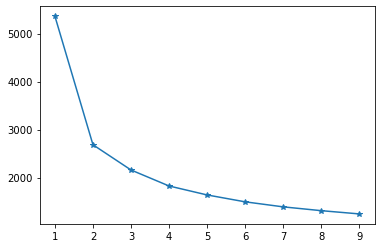

In [978]:

clusters = []
inertia_vals = []

for k in range(1, 10, 1):
    
    # train clustering with the specified K
    model = KMeans(n_clusters=k,  n_jobs=10)
    model.fit(scaled)
    inertia_vals.append(model.inertia_)
    
# plot the inertia vs K values
plt.plot(range(1,10,1),inertia_vals,marker='*')
plt.show()

Running the silhouette score method gives the below results. A significant drop is seen after 2 clusters then another drop is seen after 4 clusters. 4 clusters seems like a reasonable choice

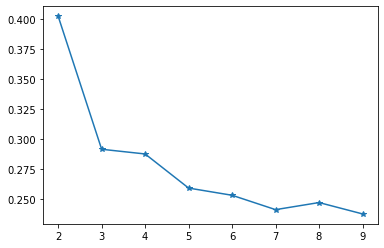

In [975]:

sil_score=[]
for i in range(1,9,1):
    sil_score.append(silhouette_score(scaled, clusters[i].predict(scaled)))    

    
plt.plot(range(2,10,1),sil_score,marker='*')
plt.show()

Next we run k-means with 4 clusters and then look at some descriptive stats for the the clusters across the chosen variables to try to understand the differences between them

In [981]:
model = KMeans(n_clusters=4,random_state=100) 
kmeans = model.fit(scaled)

cluster_merge['cluster']=kmeans.labels_

cluster_merge_stats=cluster_merge.groupby(['cluster'])['DL user tput','L.Traffic.User.Avg (None)','DL cell tput','AW_TV','EB_TV','EV_TV','NO_TV','WH_TV'].mean()

cluster_merge_stats[['DL user tput','L.Traffic.User.Avg (None)','DL cell tput','AW_TV','EB_TV','EV_TV','NO_TV','WH_TV']]

,DL user tput,L.Traffic.User.Avg (None),DL cell tput,AW_TV,EB_TV,EV_TV,NO_TV,WH_TV
cluster,,,,,,,,
0,1.220146,64.797163,8.877836,124.700548,126.821677,127.743744,129.046675,128.423355
1,2.119966,27.742232,6.128886,194.354885,180.218945,213.789998,207.973344,197.076590
2,2.126943,29.696033,5.448969,169.597405,137.919423,178.381332,165.763387,161.467071
3,1.606282,48.003868,8.717574,160.221341,159.341936,166.737066,168.966748,163.397904


Here are the main observations in the above results:

1) There are two low number of users clusters with exactly an equal throughput of around 2.12 Mbps (C1 and C2). the two cluster also have almost the same number of average connected users (27.7 to 29.7). Their average total cell throughputs are not that far off from each other either. What seems to be the differentoiator is the traffic volume oer user; C1 users have higher traffic volume and then C2 and the delta in traffic volume is not explained by the slightly higher number of connected of users. For example the number of users increases from 27.7 to 29.7 (a 7% increase) while the traffic volume drops from a high of 213 to 178 (a 16.5% drop). This means that there is more to the drop in traffic volume in C2 than simply carrying more users. C1 cells have users that are more traffic hungry than C2. Users on those cells could be looked at as high value customers in that regard

2) C0 and C3 show two other clusters with higher number of users. C3 has a medium number of user and C0 has the highest number of users. The both have the same total cell throughput (around 8.7 Mbps). The drop in traffic volume per user in C0 compated to C3 seems to be in line with the increase in the number of users (~ 25%)


The above exploratory data analysis gave us a better understanding of what we are dealing with in this data set and was a neccesary step before diving into any timeseries forecasting. The next section will go deep into the modeling process starting with problem definiton, feature selection, modeling and forecasting using different techniques